In [1]:
import glob
import os
import json

from icecream import ic
import numpy as np
from mmcv import Config
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm  # Progress bar

from functions import create_train_validation_and_test_scene_list, get_model, get_loss
from loaders import get_variable_options, AI4ArcticChallengeTestDataset, AI4ArcticChallengeDataset

torch.set_num_threads(10)

/data1/antonk/miniconda/envs/mm_seaice/lib/python3.12/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/data1/antonk/miniconda/envs/mm_seaice/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ic| args_config: 'configs/sic_mse/sic_mse_maud_01g.py'


Options train_list and validate_list initialised


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


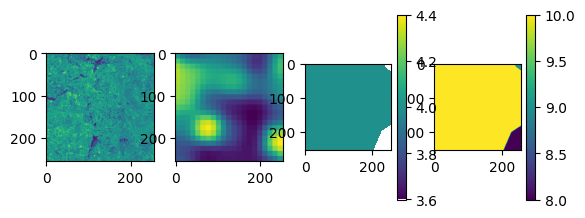

100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


torch.Size([1, 6, 1339, 1310]) (1339, 1310) (1339, 1310) torch.Size([1339, 1310]) 20211220T102441_dmi_prep.nc (2679, 2620)


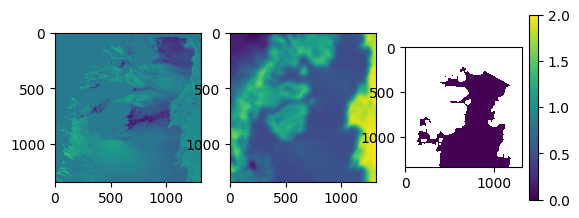

In [25]:
args_config = 'configs/sic_mse/sic_mse_maud_01g.py'
ic(args_config)
cfg = Config.fromfile(args_config)
train_options = cfg.train_options
# Get options for variables, amsrenv grid, cropping and upsampling.
train_options = get_variable_options(train_options)
device = 'cpu'
net = get_model(train_options, device)
create_train_validation_and_test_scene_list(train_options)
dataset = AI4ArcticChallengeDataset(files=train_options['train_list'][:5], options=train_options, do_transform=True)

x, y = dataset[0]
sod = np.ma.masked_where(y['SOD'][0] == 255, y['SOD'][0])
sic = np.ma.masked_where(y['SIC'][0] == 255, y['SIC'][0])

fig, axs = plt.subplots(1, 4)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
imsh2 = axs[2].imshow(sod)
plt.colorbar(imsh2, ax=axs[2], shrink=0.5)
imsh3 = axs[3].imshow(sic)
plt.colorbar(imsh3, ax=axs[3], shrink=0.5)
plt.show()

dataset_val = AI4ArcticChallengeTestDataset(options=train_options, files=train_options['validate_list'][:3], mode='train')
x, y, cfv_masks, tfv_mask, name, original_size = dataset_val[0]
print(x.shape, y['SOD'].shape, cfv_masks['SOD'].shape, tfv_mask.shape, name, original_size)
sod = np.ma.masked_where(y['SOD'] == 255, y['SOD'])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
imsh2 = axs[2].imshow(sod)
plt.colorbar(imsh2, shrink=0.5)
plt.show()

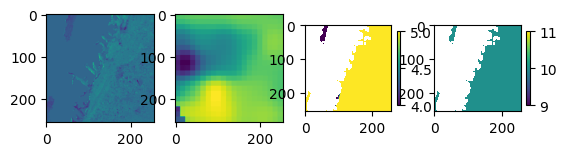

In [39]:
x, y = dataset[0]
sod = np.ma.masked_where(y['SOD'][0] == 255, y['SOD'][0])
sic = np.ma.masked_where(y['SIC'][0] == 255, y['SIC'][0])

fig, axs = plt.subplots(1, 4)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
imsh2 = axs[2].imshow(sod)
plt.colorbar(imsh2, ax=axs[2], shrink=0.2)
imsh3 = axs[3].imshow(sic)
plt.colorbar(imsh3, ax=axs[3], shrink=0.2)
plt.show()


torch.Size([1, 6, 1339, 1310]) (1339, 1310) (1339, 1310) torch.Size([1339, 1310]) 20211220T102441_dmi_prep.nc (2679, 2620)


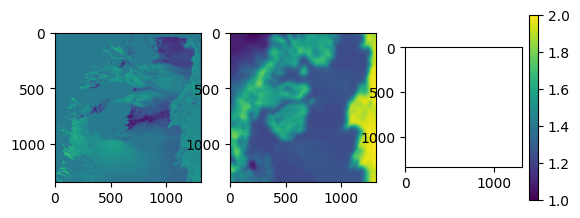

torch.Size([1, 6, 1250, 1307]) (1250, 1307) (1250, 1307) torch.Size([1250, 1307]) 20210321T194818_dmi_prep.nc (2501, 2614)


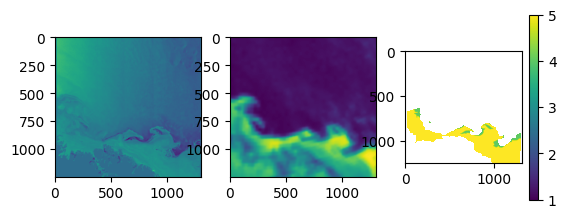

torch.Size([1, 6, 1451, 1300]) (1451, 1300) (1451, 1300) torch.Size([1451, 1300]) 20180331T212355_cis_prep.nc (2902, 2601)


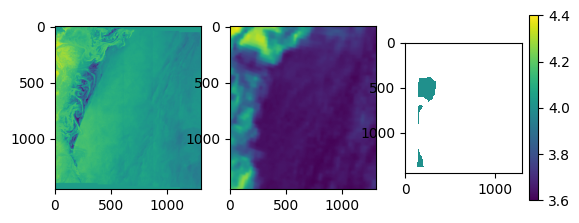

In [6]:
for x, y, cfv_masks, tfv_mask, name, original_size in dataset_val:
    print(x.shape, y['SOD'].shape, cfv_masks['SOD'].shape, tfv_mask.shape, name, original_size)
    sod = np.ma.masked_where(cfv_masks['SOD'], y['SOD'])
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(x[0, 0])
    axs[1].imshow(x[0, 5])
    imsh2 = axs[2].imshow(sod)
    plt.colorbar(imsh2, shrink=0.5)
    plt.show()

In [ ]:
args_config = 'configs/sic_mse/sic_mse_maud_02c.py'
ic(args_config)
cfg = Config.fromfile(args_config)
train_options = cfg.train_options
# Get options for variables, amsrenv grid, cropping and upsampling.
train_options = get_variable_options(train_options)
device = 'cpu'
net = get_model(train_options, device)
create_train_validation_and_test_scene_list(train_options)

In [ ]:
dataset = AI4ArcticChallengeDataset(files=train_options['train_list'][:5], options=train_options, do_transform=True)

In [ ]:
x, y = dataset[0]
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
axs[2].imshow(y['SIR02'][0], clim=[0, 7])
plt.show()

In [ ]:
dataset.options

In [9]:
dataloader_train = torch.utils.data.DataLoader(
        dataset, batch_size=None, shuffle=True, num_workers=train_options['num_workers'], pin_memory=True)

In [ ]:
for x, y in dataloader_train:
    break
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
axs[2].imshow(y['SIR06'][0], clim=[0, 7])
plt.show()

In [ ]:
dataset_val = AI4ArcticChallengeTestDataset(options=train_options, files=train_options['validate_list'], mode='train')

In [ ]:
x, y, cfv_masks, tfv_mask, name, original_size = dataset_val[4]
print(x.shape, y['SIR00'].shape, cfv_masks['SIR00'].shape, tfv_mask.shape, name, original_size)
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[0, 0])
axs[1].imshow(x[0, 5])
axs[2].imshow(y['SIR00'])
plt.show()

In [4]:
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=None, num_workers=train_options['num_workers_val'], shuffle=False)


In [5]:
loss_ce_functions = {chart: get_loss(train_options['chart_loss'][chart]['type'], chart=chart, **train_options['chart_loss'][chart])
                         for chart in train_options['charts']}

In [ ]:
for i, (inf_x, inf_y, cfv_masks, tfv_mask, name, original_size) in enumerate(tqdm(iterable=dataloader_val,
                                                                    total=len(train_options['validate_list']),
                                                                    colour='green')):
    with torch.no_grad():
        inf_x = inf_x.to(device, non_blocking=True)
        output = net(inf_x)

        for chart, weight in zip(train_options['charts'], train_options['task_weights']):

            val_cross_entropy_loss = weight * loss_ce_functions[chart](
                output[chart][:,:,~cfv_masks[chart]],
                inf_y[chart][~cfv_masks[chart]].unsqueeze(0).long().to(device)
            )
    print(name, val_cross_entropy_loss, np.unique(inf_y['SIR12']))


In [ ]:
output[chart].shape, inf_y[chart].shape, inf_y[chart].unsqueeze(0).shape

In [ ]:
loss_ce_functions[chart](output[chart], inf_y[chart].unsqueeze(0).long().to(device))

In [ ]:
_output = output[chart][:,:,~cfv_masks[chart]]
_target = inf_y[chart][~cfv_masks[chart]].unsqueeze(0).long()
_output.shape, _target.shape

In [ ]:
loss_ce_functions[chart](_output, _target.to(device))

In [ ]:
help(loss_ce_functions[chart])

In [ ]:
plt.imshow(cfv_masks['SIR12'])